In [264]:
#Import necessary libraries
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import math

In [265]:
class CustomError(Exception):
    """Custom exception for handling specific errors."""
    def __init__(self, message="An error occurred"):
        self.message = message
        super().__init__(self.message)

In [266]:
def create_dataframe(filename):
    """ Takes Filename (1 arg) and returns a DataFrame with the relevant data."""
    time_data = []
    stop_data = []
    token_data = []
    with open('active_data/' + filename, 'r', encoding='utf-8') as f:
        for line in f:
                if "logprobs" in line:
                #Add relevant other data
                    pattern = re.compile(r"'finish_reason': '([^']*).*prompt_tokens': (\d*).*completion_tokens': (\d*).*total_tokens': (\d*)")
                #individually append all 4 groups, finish reason, prompt tokens, completion tokens, total tokens
                    match = re.search(pattern, line)
                    if match:
                        for group in match.groups():
                            if group.isdigit():
                                to_be_appended = int(group)
                                token_data.append(to_be_appended)
                            else:
                                stop_data.append(group)
                    else:
                        CustomError("No match found for other data in line: {}".format(line))
                elif "llama_perf_context_print" in line:
                #RE pattern for just grabbing numbers
                    pattern = r"\d+(?:\.\d+)?"
                #Adds timing data
                    if "load time" in line:
                        matches = re.findall(pattern, line)
                        if len(matches) == 1:
                            time_data.append(float(matches[0])/1000)  # Load Time
                        else:
                            CustomError("Unexpected number of matches for load time. Expected 1, got {}".format(len(matches)))
                    elif "eval time" in line:
                    #!! Grabs both eval time and prompt eval time
                        matches = re.findall(pattern, line)
                        if len(matches) == 4:
                            time_data.append(float(matches[0])/1000) 
                            time_data.append(int(matches[1]))
                            time_data.append(float(matches[2])/1000)
                            time_data.append(float(matches[3]))
                        else:
                            CustomError("Unexpected number of matches for eval time. Expected 4, got {}".format(len(matches)))
                    elif "total time" in line:
                        matches = re.findall(pattern, line)
                        if len(matches) == 2:
                            time_data.append(float(matches[0])/1000)
                            time_data.append(float(matches[1]))
                        else:
                            CustomError("Unexpected number of matches for total time. Expected 1, got {}".format(len(matches)))



    #Setting up and shaping time data
    num_experiments = len(time_data) // 11
    
    #Old debug to findout if the data was incomplete 
    # print(num_experiments)

    time_data_reshaped = np.array(time_data).reshape(num_experiments, 11)
    df_main = pd.DataFrame(time_data_reshaped, columns=['Load Time', 'Prompt Eval Time', 'Prompt Eval Tokens', 'Prompt Eval Time Per Token', 'Prompt Eval Tokens Per Sec', 'Eval Time','Eval Tokens', 'Eval Time per token', 'Eval Tokens Per Sec', 'Total Time', 'Total Tokens (high)'])


    #Setting up and shaping other data

    num_experiments = len(stop_data) // 1
    stop_data_reshaped = np.array(stop_data).reshape(num_experiments, 1)
    df_other = pd.DataFrame(stop_data_reshaped, columns=['Finish Reason'])

    num_experiments = len(token_data) // 3
    token_data_reshaped = np.array(token_data).reshape(num_experiments, 3)
    df_tokens = pd.DataFrame(token_data_reshaped, columns=['Prompt Tokens', 'Completion Tokens', 'Total Tokens (low)'])

    final_df = pd.concat([df_main, df_other, df_tokens], axis=1)
    #final_df['LLM'] = filename.split('.')[0]  # Extract LLM name from filename::: Excluded as there are multiple "Gemma" models
    return final_df
    

In [267]:
def merge_dataframes():
    """Merges all dataframes from the 'active_data' directory into a single dataframe"""
    #Multi DataFrame Plotting
    dataframe_list = []
    for path in os.listdir('active_data'):
        df = create_dataframe(path)
        dataset_name = path.split('_')[0]
        # Add a new column to identify the dataset
        df["Dataset"] = dataset_name
        dataframe_list.append(df)
    my_dataframe = pd.concat(dataframe_list, ignore_index=True)
    return my_dataframe

In [268]:
def twenty_five_average_prompt_data(group):
    """
    Takes a DataFrame group and calculates the average for each of the 25 run cycles.
    Assumes data is structured in repeating blocks of 25 rows.
    """
    # Initialize an empty list to store the average
    run_averages = []
    prompts = ["What is the capital of Hungary?", "Classify the sentiment of the following review: 'The food was cold and the service was terrible.' Answer with Positive, Neutral, or Negative.", "If a train leaves at 2:00 PM traveling 60 miles per hour, how far will it travel in 2.5 hours?", "Is the following news headline about politics, sports, or entertainment? 'Senate passes new infrastructure bill after bipartisan agreement.'", "Translate this sentence to French: 'The cat is sleeping on the couch.'", "If you drop a glass on a concrete floor, what happens?", "Write a Python function that returns the factorial of a number.", "Man is to woman as king is to ___.", "Correct the grammar in this sentence: 'She don’t like the cold weather.'", "What does the word ambivalent mean?", "Passage: Emma walked into the room and turned on the light. The window was open, and the breeze made the curtains flutter. She smiled, remembering summers at her grandmother’s house. Question: What is the mood of the passage?", "Who painted the Mona Lisa?", "If a bat and a ball cost $1.10 in total, and the bat costs $1.00 more than the ball, how much does the ball cost?", "You’re at a restaurant and you drop your glass. It shatters. What should you do next?", "What is the square root of 144?", "You have 6 apples. You give 2 to John and cut the rest in half. How many apple pieces do you have?", "Write a short story about a robot who discovers music.", "Rewrite this sentence to sound more formal: ‘I’m gonna be late to the meeting.’", "Translate this sentence to German: ‘I would like a coffee, please.’", "Label the sentiment of this review as Positive, Negative, or Neutral: ‘The service was okay, but the food was fantastic.’", "Identify all people, organizations, and locations in this sentence: ‘Apple Inc. hired Jane Smith to manage its new office in Berlin.’", "Write a Python function that returns the Fibonacci sequence up to n.", "Here's a sentence: 'Wow, thanks for that brilliant idea.' What kind of tone does this sentence use?", "You are a pirate. Greet me in pirate talk.", "List three benefits of solar power in bullet points."]
    
    for run_number in range(25):
        #Select all rows corresponding to the current run number
        # e.g., for run_number=0, this selects rows 0, 25, 50, ...
        selected_rows = group.iloc[run_number::25]

        # 3. Calculate the average for these rows and append it to our list
        average_of_selected = selected_rows.mean(numeric_only=True)
        run_averages.append(average_of_selected)

    # 4. Concatenate the list of averages into a single DataFrame after the loop
    # We combine the Series as columns and then Transpose (.T) to make them rows.
    final_df = pd.concat(run_averages, axis=1).T
    final_df["Dataset"] = group["Dataset"].iloc[0]  # Add the dataset name
    final_df['Prompt'] = prompts
    final_df = final_df.reset_index(drop=True)

    return final_df

In [269]:
def ninety_average_prompt_data(dataframe):
    """
    Takes a DataFrame group and calculates the average for each of the 90 run cycles.
    Assumes data is structured in repeating blocks of 90 rows.
    """
    # Initialize promts to be appended to the final dataframe
    prompts = ["What is the capital of Australia?", "Translate the following English sentence to Spanish: 'How are you today?'", "Is the following statement true or false? 'The Earth is flat.'", "Identify the primary emotion expressed in the following sentence: 'I am absolutely thrilled about the new project!'", "Convert 100 degrees Celsius to Fahrenheit.", "What is the largest mammal on Earth?", "Write a single sentence describing the function of a heart.", "What is the chemical symbol for gold?", "Classify the following animal as a mammal, reptile, or bird: 'Penguin'", "Explain the concept of supply and demand in economics in one short paragraph.", "Input: 'The cat sat on the mat.' Part-of-speech tagged: The(DET) cat(NOUN) sat(VERB) on(PREP) the(DET) mat(NOUN). Input: 'Birds fly high.' Part-of-speech tagged: Birds(NOUN) fly(VERB) high(ADV). Input: 'She quickly ran to the store.' Part-of-speech tagged:", "Movie Title: 'Inception' Genre: Science Fiction Movie Title: 'The Shawshank Redemption' Genre: Drama Movie Title: 'Jurassic Park' Genre:", "Review: 'Loved the food, but the service was slow.' Sentiment: Mixed Review: 'Absolutely terrible, waste of money.' Sentiment: Negative Review: 'This product exceeded all my expectations.' Sentiment:", "Simplify: x + x + y Result: 2x + y Simplify: 3a + 2b - a Result: 2a + 2b Simplify: 5p - 2p + 4q Result:", "Synonym for 'happy': joyful Synonym for 'sad': sorrowful Synonym for 'big':", "Country: France Capital: Paris Country: Germany Capital: Berlin Country: Italy Capital:", "Input: 'It's raining cats and dogs.' Meaning: Raining very heavily. Input: 'He's feeling under the weather.' Meaning: Feeling unwell. Input: 'She spilled the beans.' Meaning:", "Input: 'Dr. Smith presented at the conference.' Entities: Dr. Smith (PERSON) Input: 'Apple Inc. announced new iPhones.' Entities: Apple Inc. (ORG), iPhones (PRODUCT) Input: 'The Eiffel Tower is in Paris.' Entities:", "Input: 'convert 10 miles to kilometers' Tool Use: convert_units(10, 'miles', 'kilometers') Input: 'calculate square root of 64' Tool Use: calculate_math(sqrt(64)) Input: 'find today's weather in London' Tool Use:", "Summary of: 'The cat chased the mouse. The mouse ran into its hole.' Summary: The cat hunted the mouse, which escaped into its hole. Summary of: 'The sun rose, painting the sky with vibrant colors. Birds began to sing.' Summary: The sunrise brought a colorful sky and the sound of singing birds. Summary of: 'Scientists discovered a new exoplanet. It is twice the size of Earth and orbits a star similar to our sun.' Summary:", "If a baker bakes 20 cakes in 4 hours, and his assistant bakes 15 cakes in 5 hours, how many cakes can they bake together in 2 hours? Let's break this down.", "I have a rectangular garden plot that is 10 meters long and 8 meters wide. If I want to put a fence around it, and fencing costs $5 per meter, how much will the fence cost? Show your steps.", "Sarah is older than Tom. Tom is older than Lisa. Lisa is older than Mark. Is Sarah older than Mark? Explain your reasoning.", "If an item is discounted by 20%, and then an additional 10% is taken off the discounted price, what is the total percentage discount from the original price? Think step by step.", "You have three boxes. One is labeled 'Apples,' one is labeled 'Oranges,' and one is labeled 'Apples and Oranges.' You know that every box is incorrectly labeled. You can only pick one fruit from one box. Which box would you pick from to correctly label all three boxes? Explain your thought process.", "A cyclist travels 60 miles in 3 hours. If they maintain the same average speed, how long will it take them to travel 100 miles? Break down the calculation.", "If today is Tuesday, what day of the week will it be in 100 days? Think step by step.", "You are planning a party. You need 3 sodas for every 2 guests. If you expect 18 guests, how many sodas do you need? Show your calculations.", "Evaluate the expression: 5 + (3 * (8 - 4)) / 2. Show each step according to order of operations.", "What is the sum of all integers from 1 to 10? Explain how you arrived at the answer.", "What was the winning country of the FIFA World Cup in 2018?", "How many days are there between today's date and December 25th, 2025?", "If a car travels at an average speed of 70 km/h, how long will it take to cover 500 km?", "What is the current stock price of Google (GOOGL)?", "Find a recent news headline about artificial intelligence.", "What is the recipe for a classic Spaghetti Carbonara?", "Calculate the square root of 256.", "Who directed the movie 'Oppenheimer' and what year was it released?", "What are the main features of the latest iPhone model?", "If a store has a 30% off sale on an item that originally costs $150, what is the final price after the discount?", "Summarize the following paragraph in one sentence: 'The invention of the printing press by Johannes Gutenberg in the 15th century revolutionized the spread of information. Before its advent, books were painstakingly copied by hand, making them expensive and rare. The printing press enabled the mass production of texts, leading to increased literacy, the wider dissemination of knowledge, and a profound impact on science, religion, and politics across Europe.'", "Provide a 2-3 sentence summary of the following excerpt: 'Climate change refers to long-term shifts in temperatures and weather patterns. These shifts may be natural, but since the 1800s, human activities have been the main driver of climate change, primarily due to the burning of fossil fuels (like coal, oil, and gas) which produces heat-trapping gases. The consequences of climate change include rising sea levels, more extreme weather events, disruptions to ecosystems, and threats to human health and food security.'", "Condense the following short story into a paragraph of no more than 50 words: 'Elara, a young elf, lived in a hidden village deep within the Whispering Woods. One day, a dark blight began to spread, slowly turning the ancient trees to ash. The elders believed it was a curse, but Elara, brave and curious, ventured out, following a faint, glowing trail. It led her to a forgotten spring, polluted by a shadowy crystal. With courage and a pure heart, she touched the crystal, absorbing its darkness and transforming it into light, healing the woods and saving her people.'", "Summarize the key argument made in the following research abstract: 'This paper proposes a novel deep learning architecture for image recognition that significantly reduces computational overhead while maintaining high accuracy. Through the implementation of a sparse attention mechanism and a compressed convolutional layer, our model achieves a 30% reduction in parameters and a 45% faster inference time compared to state-of-the-art models on the ImageNet dataset, with only a 0.5% drop in accuracy. These results suggest a promising direction for deploying complex vision models on resource-constrained devices.'", "Provide a headline-style summary (less than 10 words) of the following event: 'A powerful earthquake, measuring 7.8 on the Richter scale, struck the coast of Japan early Tuesday morning, triggering tsunami warnings and causing widespread damage to infrastructure and buildings. Authorities have urged residents in coastal areas to evacuate immediately as rescue efforts begin.'", "Summarize the main characteristics of a 'black hole' based on the text below: 'A black hole is a region of spacetime where gravity is so strong that nothing—no particles or even electromagnetic radiation like light—can escape from it. The theory of general relativity predicts that a sufficiently compact mass can deform spacetime to form a black hole. The boundary of the region from which no escape is possible is called the event horizon. Although it obstructs the passage of light, its presence can be inferred through its interaction with other matter and electromagnetic radiation, such as the disruption of nearby stars and active galactic nuclei.'", "Create a two-sentence news brief from this press release excerpt: 'Quantum Leap Corp. announced today the successful development of QLC-001, a revolutionary battery technology promising to extend electric vehicle range by 50% and reduce charging times by 70%. The company plans to begin pilot manufacturing in Q3 2025, with full commercial production anticipated by mid-2026. This breakthrough is expected to significantly accelerate the global transition to sustainable transportation.'", "Summarize the plot of 'Romeo and Juliet' in about 3-4 sentences.", "Extract the key takeaway message from the following motivational quote: 'The only way to do great work is to love what you do. If you haven't found it yet, keep looking. Don't settle. As with all matters of the heart, you'll know when you find it.'", "Summarize the process of photosynthesis in simple terms (2 sentences).", "Extract the full name, company, and job title from the following: 'For inquiries, please contact our Head of Marketing, Ms. Eleanor Vance, at Global Innovations Inc.'", "From the product description, list the product name, price, and available colors: 'Introducing the new Aurora Smartwatch! Priced at $299.99, this device comes in Midnight Black, Arctic Silver, and Rose Gold. Limited stock available.'", "Extract the date, city, and performing artist from the concert announcement: 'Don't miss 'The Lumineers' live in concert! Coming to the Fillmore in San Francisco on October 27, 2025.'", "From the research abstract, identify the key finding and the methodology used: 'Our study investigated the effects of mindfulness meditation on stress reduction in university students. Using a randomized controlled trial design with 120 participants, we found a statistically significant reduction in perceived stress levels (p < 0.01) in the intervention group compared to the control group.'", "List all ingredients from the recipe instructions: 'First, sauté one onion and two cloves of garlic in olive oil. Then, add 400g of chopped tomatoes, 200ml of vegetable broth, and a pinch of basil and oregano. Simmer for 20 minutes.'", "From the job posting, extract the required experience level and any mandatory programming languages: 'We are seeking a Senior Software Engineer with at least 5 years of experience in Python. Knowledge of Java is a plus, but Python is required. Must have experience with cloud platforms.'", "Identify the sender, recipient, and subject of the email fragment: 'From: alex.smith@example.com To: project_team@example.com Subject: Meeting Agenda for Q3 Planning Hi Team, please review the attached agenda...'", "From the medical note, extract the patient's age, diagnosis, and prescribed medication: 'Patient: Jane Doe, Age: 45. Diagnosis: Type 2 Diabetes. Prescribed: Metformin 500mg twice daily.'", "Extract the product name, model number, and manufacturer from the following: 'This is the new 'UltraBlend Pro' blender, Model BL-7000, manufactured by KitchenMaster Inc.'", "From the academic citation, extract the author(s), publication year, and journal name: 'Smith, J., & Johnson, A. (2023). The Impact of AI on Modern Education. Journal of Learning Technologies, 15(2), 123-145.'", "What is the largest ocean on Earth?", "Based on the passage: 'The human brain consumes about 20% of the body's total oxygen and calories, despite accounting for only 2% of the body's weight.', what percentage of the body's oxygen does the human brain consume?", "Who wrote 'To Kill a Mockingbird'?", "According to the text: 'The earliest known writing system, cuneiform, emerged in Mesopotamia around 3500-3000 BCE.', when did cuneiform emerge and where?", "What is the process by which plants convert light energy into chemical energy?", "From the following statement: 'The company's revenue increased by 15% in Q1, driven primarily by strong sales in the European market.', what was the main driver of revenue increase in Q1?", "Which planet is known as the 'Red Planet'?", "Based on this information: 'Mount Everest is the Earth's highest mountain above sea level, located in the Mahalangur Himal sub-range of the Himalayas. Its summit is 8,848.86 meters (29,031.7 feet) above sea level.', how high is Mount Everest in feet?", "What is the primary gas responsible for the Earth's greenhouse effect?", "According to the provided recipe: 'Mix flour, sugar, and baking powder. Add eggs and milk, stir until smooth. Pour into a greased pan and bake at 350°F for 30 minutes.', what temperature should the oven be set to for baking?", "Classify the following news article title into one of these categories: [Sports, Politics, Technology, Business, Health]: 'Tech Giant Unveils New AI-Powered Smartwatch'", "Categorize the sentiment of the following customer review: [Positive, Negative, Neutral]: 'The delivery was fast, but the product arrived damaged.'", "Classify the following email subject line as [Spam, Work, Personal, Marketing]: 'URGENT: Your account has been compromised! Click here now!'", "What is the domain of the following research paper title: [Physics, Biology, Chemistry, Computer Science, Economics]: 'Quantum Entanglement in Superconducting Qubits'", "Categorize the following short text based on its genre: [News Report, Advertisement, Recipe, Poem]: 'Preheat oven to 375°F. Mix flour, sugar, eggs, and milk. Bake for 25 minutes.'", "Classify the following sentence as pertaining to [History, Geography, Science, Arts]: 'The Roman Empire fell in 476 AD, marking the end of ancient civilization in Europe.'", "What is the primary purpose of this sentence: [Inform, Persuade, Entertain, Instruct]: 'Buy now and get 50% off for a limited time!'", "Classify the following product description based on product type: [Apparel, Electronics, Home Goods, Food]: 'A lightweight, noise-cancelling over-ear headphone with Bluetooth connectivity.'", "Assign a customer service issue type to the following query: [Billing, Technical Support, Product Inquiry, Returns]: 'My Wi-Fi keeps disconnecting, and I can't access the internet.'", "Classify the following book title based on its likely subject: [Fiction, Non-fiction]: 'The History of the World in 100 Objects'","CONVERSATION: Fantasy Book Recommendation", "CONVERSATION: Broken Internet", "CONVERSATION: Whats the weather like today?", "CONVERSATION: Tell me a bit about ai", "CONVERSATION: Flight to London", "CONVERSATION: Feeling a bit down", "CONVERSATION: Best way to leanr new programming languare?", "CONVERSATION: Tell me a joke", "CONVERSATION: Need help planning a healthy meal","CONVERSATION: Story behind Mona Lisa"]
  
    num_repeats = math.ceil(len(dataframe) / len(prompts))

    # Create the new list by repeating the prompts list
    # and slice it to the exact length of the DataFrame
    full_prompt_list = (prompts * num_repeats)[:len(dataframe)]

    # Assign the new list to the 'Prompt' column
    dataframe['Prompt'] = full_prompt_list

    count = 0
    for index in dataframe.index:
        # Check the index number (0-9 corresponds to the first 10 rows)
        if index%90 < 10:
            dataframe.loc[index, 'Q_type'] = 'Zero-Shot'
        elif index%90 < 20:
            dataframe.loc[index, 'Q_type'] = 'Few-Shot'
        elif index%90 < 30:
            dataframe.loc[index, 'Q_type'] = 'Chain-of-Thought'
        elif index%90 < 40:
            dataframe.loc[index, 'Q_type'] = 'ReAct'
        elif index%90 < 50:
            dataframe.loc[index, 'Q_type'] = 'Text-Summarization'
        elif index%90 < 60:
            dataframe.loc[index, 'Q_type'] = 'Information Extraction'
        elif index%90 < 70:
            dataframe.loc[index, 'Q_type'] = 'Question-Answering'
        elif index%90 < 80:
            dataframe.loc[index, 'Q_type'] = 'Text-Classification'
        elif index%90 < 90:
            dataframe.loc[index, 'Q_type'] = 'Conversation'
        else:
            # This part of the code will now work as intended
            raise ValueError("Too many rows in dataframe to assign Q_type")
            
    return dataframe

In [270]:
os.listdir('active_data')
#Gather Data Filenames from active data

['gemma3-12b-z-1100%_2025-08-02-02-41-03.txt',
 'gemma3-12b-z-1200%_2025-08-04-11-14-20.txt',
 'llama3.2-1b-z-1100%_2025-08-02-02-41-03.txt',
 'llama3.2-1b-z-1200%_2025-08-04-11-14-20.txt',
 'llama3.2-3b-z-1100%_2025-08-02-02-41-03.txt',
 'llama3.2-3b-z-1200%_2025-08-04-11-14-20.txt']

In [271]:
#Set up the data analysis


#Combine all files in active data directory into a single DataFrame
combined_dataframe = merge_dataframes()
combined_dataframe
with_promtps = ninety_average_prompt_data(combined_dataframe)
print(with_promtps.to_string())


#Average the prompt data across all runs
#grouped_data = combined_dataframe.groupby('Dataset').apply(twenty_five_average_prompt_data)
with_promtps.to_csv('LLM_Dataframe.csv')
#print(grouped_data.to_string())

     Load Time  Prompt Eval Time  Prompt Eval Tokens  Prompt Eval Time Per Token  Prompt Eval Tokens Per Sec  Eval Time  Eval Tokens  Eval Time per token  Eval Tokens Per Sec  Total Time  Total Tokens (high) Finish Reason  Prompt Tokens  Completion Tokens  Total Tokens (low)              Dataset                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Prompt                  Q_type
0      1.05306        

In [272]:
# #Save to json for d3.js visualization, DROPPPED FOR NOW
# #Not looking great, i think ill drop for now :(

# your_large_df = grouped_data


# # After loading your data, e.g., df = pd.read_csv(...)
# print(your_large_df.columns)
# # --- 2. Define which columns you want to plot ---
# x_axis_col = 'Eval Tokens'
# y_axis_col = 'Total Time'
# caption_col = 'Prompt'
# category_col = 'Dataset' # The column to color by

# # --- 3. Create a new, smaller DataFrame ---
# # Note: We now select four columns
# plot_df = your_large_df[[x_axis_col, y_axis_col, caption_col, category_col]].copy()

# # --- 4. Rename the columns to match the D3 script's expectations ---
# plot_df.rename(columns={
#     x_axis_col: 'x',
#     y_axis_col: 'y',
#     caption_col: 'caption',
#     category_col: 'category' # Rename to the generic 'category' key
# }, inplace=True)

# # --- 5. Save the result to 'data.json' ---
# plot_df.to_json('data.json', orient='records', indent=4)


<Axes: xlabel='Prompt Eval Tokens', ylabel='Prompt Eval Time'>

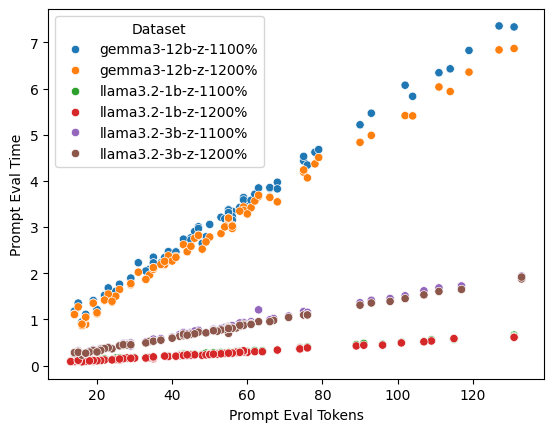

In [273]:
sns.scatterplot(data=combined_dataframe, x='Prompt Eval Tokens', y='Prompt Eval Time', hue='Dataset')


<Axes: xlabel='Dataset', ylabel='Eval Tokens'>

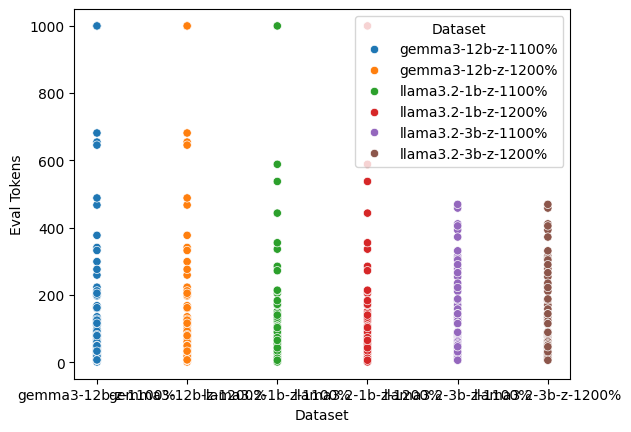

In [274]:
sns.scatterplot(data=combined_dataframe, x='Dataset', y='Eval Tokens', hue='Dataset')

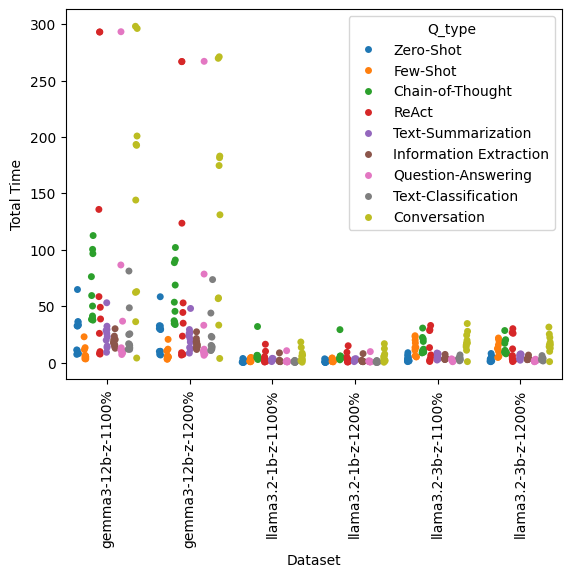

In [275]:
# sns.scatterplot(data=combined_dataframe, x='Dataset', y='Eval Tokens', hue='Q_type')

sns.stripplot(data=combined_dataframe, x='Dataset', y='Total Time', hue='Q_type', jitter=True, dodge=True)
plt.xticks(rotation=90)
#plt.axhline(y=20, color='r', linestyle='--')
plt.show()

<Axes: xlabel='Eval Tokens', ylabel='Eval Time'>

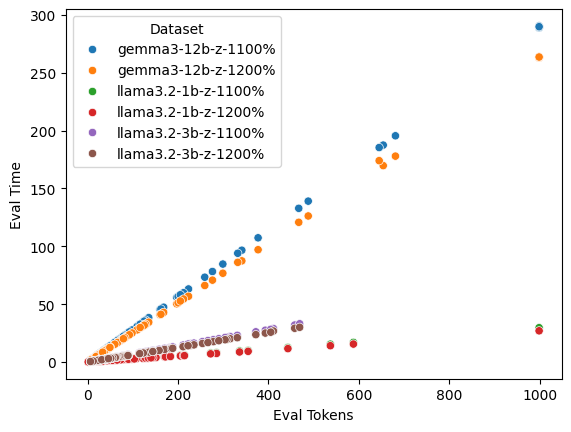

In [276]:
sns.scatterplot(data=combined_dataframe, x='Eval Tokens', y='Eval Time', hue='Dataset')


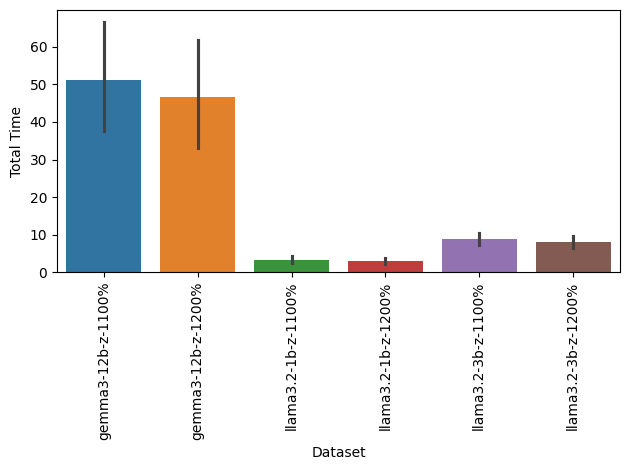

In [277]:
sns.barplot(data=with_promtps, x='Dataset', y='Total Time', hue='Dataset')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


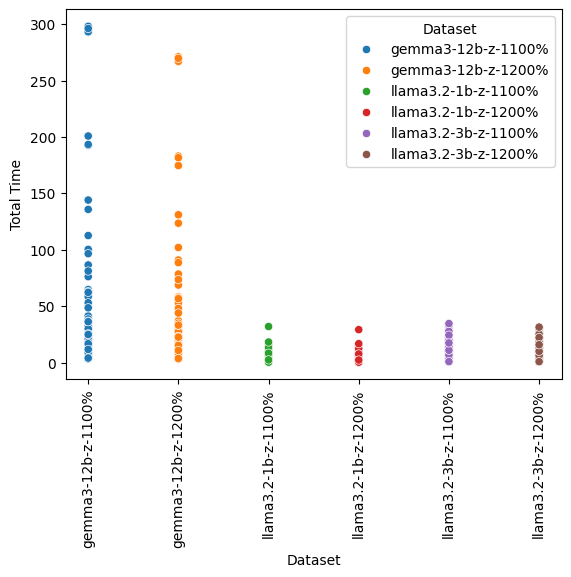

In [278]:
sns.scatterplot(data=with_promtps, x='Dataset', y='Total Time', hue='Dataset')
plt.xticks(rotation=90)
plt.show()

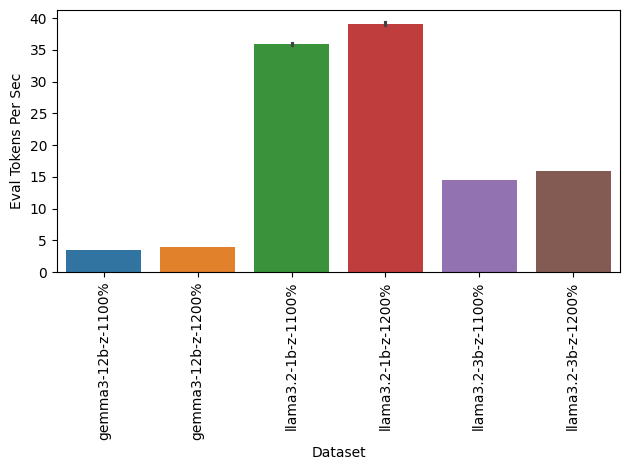

In [279]:
sns.barplot(data=with_promtps, x='Dataset', y='Eval Tokens Per Sec', hue='Dataset')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [280]:
# #Only For small LLM things, Q-type comparison
# q_type_comp = sns.barplot(data=with_promtps, x='Q_type', y='Eval Time', hue='Dataset')
# plt.setp(q_type_comp.xaxis.get_majorticklabels(), ha='right')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


<Axes: xlabel='Eval Tokens Per Sec', ylabel='Total Time'>

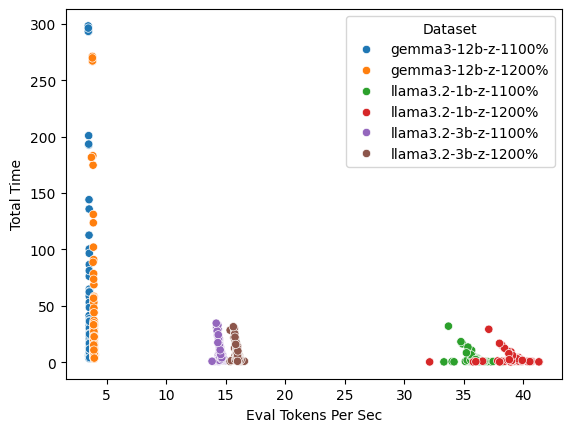

In [281]:
sns.scatterplot(data=combined_dataframe, x='Eval Tokens Per Sec', y='Total Time', hue='Dataset')

<Axes: xlabel='Total Tokens (high)', ylabel='Total Time'>

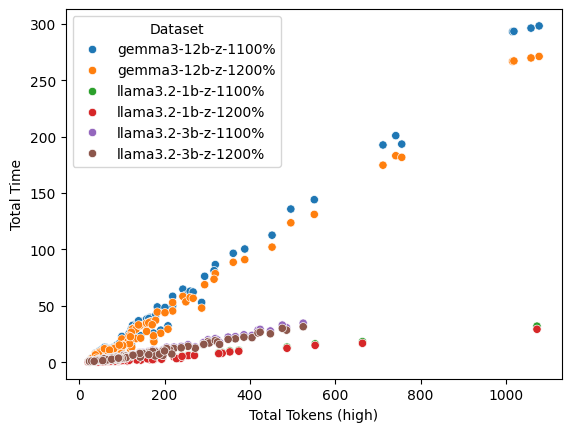

In [282]:
sns.scatterplot(data=combined_dataframe, x='Total Tokens (high)',y='Total Time', hue='Dataset')

<Axes: xlabel='Finish Reason', ylabel='count'>

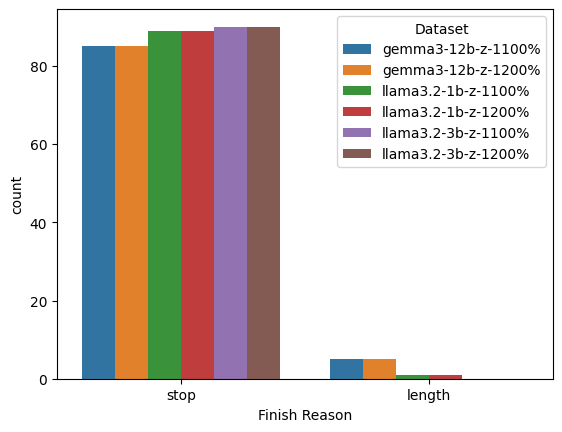

In [283]:
sns.countplot(data=combined_dataframe, x='Finish Reason', hue='Dataset')

([<matplotlib.patches.Wedge at 0x1ff82c862a0>,
 [Text(-1.0973204557467513, 0.07673211452672334, 'stop'),
  Text(1.097320462454882, -0.07673201859591824, 'length')],
 [Text(-0.5985384304073188, 0.04185388065093999, '97.8%'),
  Text(0.5985384340662991, -0.04185382832504631, '2.2%')])

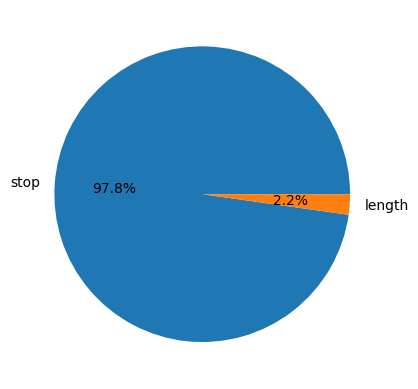

In [284]:
# This requires matplotlib.pyplot, usually imported as plt

plt.pie(combined_dataframe['Finish Reason'].value_counts(), labels=combined_dataframe['Finish Reason'].value_counts().index, autopct='%1.1f%%')


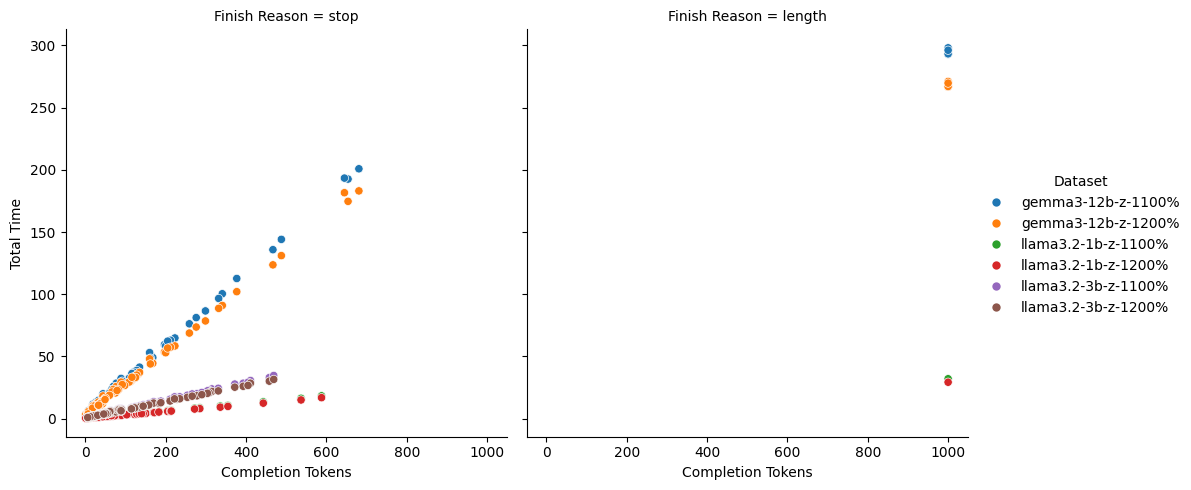

In [285]:
sns.relplot(data=combined_dataframe, x='Completion Tokens', y='Total Time', col='Finish Reason', kind='scatter', hue='Dataset')

In [286]:
# #All boxplots of quantitative variables by dataset and question type, CURRENTLY COMMENTED OUT
# quantitative_vars = ['Prompt Eval Time', 'Prompt Eval Tokens', 'Prompt Eval Time Per Token', 'Prompt Eval Tokens Per Sec', 'Eval Time','Eval Tokens', 'Eval Time per token', 'Eval Tokens Per Sec', 'Total Time', 'Total Tokens (high)', 'Prompt Tokens', 'Completion Tokens', 'Total Tokens (low)']

# # Outer loop iterates through each unique dataset (LLM)
# for dataset in with_promtps['Dataset'].unique():
#     # Inner loop iterates through each quantitative variable
#     for quant_var in quantitative_vars:
        
#         plt.figure(figsize=(10, 6))
#         subset_df = with_promtps[with_promtps['Dataset'] == dataset]
#         sns.boxplot(data=subset_df, x='Q_type', y=quant_var)
        
#         plt.title(f'Distribution of "{quant_var}" for LLM: {dataset}', fontsize=16)
#         plt.xlabel('Question Type', fontsize=12)
#         plt.ylabel(quant_var, fontsize=12)
        
#         # Rotate the x-axis labels for better readability
#         plt.xticks(rotation=45, ha='right')
        
#         plt.tight_layout()
#         plt.show()

In [292]:
summary_stats = combined_dataframe.groupby('Dataset')['Total Time'].agg(['mean', 'median', 'std']).reset_index()


previous_mean = summary_stats['mean'].shift(1)
# Calculate the improvement. The first row will be NaN. ONLY FOR CPU CAP DATA
summary_stats['Percent improvement (mean)'] = ((previous_mean - summary_stats['mean']) / previous_mean) * 100
# Replace the NaN in the first row with 0
summary_stats['Percent improvement (mean)'] = summary_stats['Percent improvement (mean)'].fillna(0)
summary_stats['Percent improvement (mean)']



summary_stats

,Dataset,mean,median,std,Percent improvement (mean)
0,gemma3-12b-z-1100%,51.167761,24.157215,72.199019,0.000000
1,gemma3-12b-z-1200%,46.555663,21.951295,65.833784,9.013678
2,llama3.2-1b-z-1100%,3.135539,1.665670,4.505925,93.264968
3,llama3.2-1b-z-1200%,2.876433,1.521265,4.123461,8.263531
4,llama3.2-3b-z-1100%,8.740474,4.983540,8.451481,-203.865089
5,llama3.2-3b-z-1200%,7.997463,4.594835,7.712636,8.500810


In [288]:
# for quant_var in quantitative_vars:
        
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(data=with_promtps, x='Dataset', y=quant_var)
    
#     plt.title(f'Distribution of "{quant_var}" for LLMS', fontsize=16)
#     plt.xlabel('LLM', fontsize=12)
#     plt.ylabel(quant_var, fontsize=12)
    
#     # Rotate the x-axis labels for better readability
#     plt.xticks(rotation=45, ha='right')
    
#     plt.tight_layout()
#     plt.show()

In [289]:
duplicates = combined_dataframe.duplicated(subset = 'Total Time')
print("Duplicates found:", duplicates.sum())

Duplicates found: 0


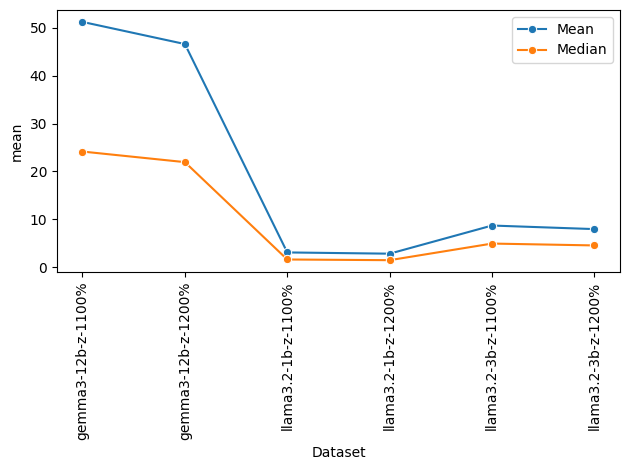

In [290]:
sns.lineplot(data=summary_stats, x='Dataset', y='mean', label='Mean', marker='o')
sns.lineplot(data=summary_stats, x='Dataset', y='median', label='Median', marker='o')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

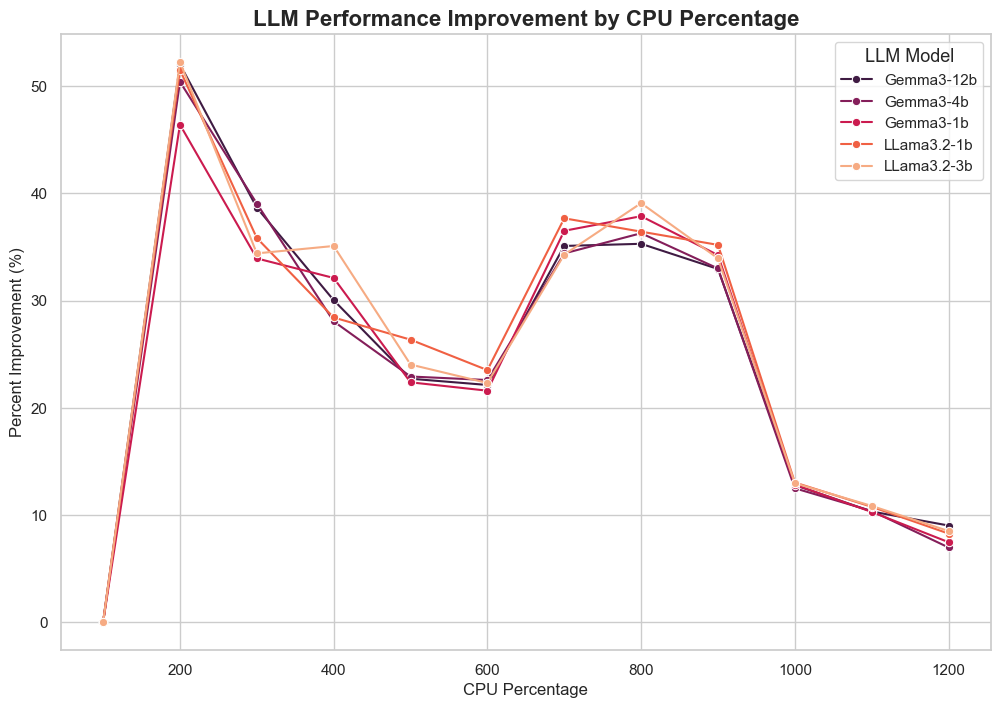

In [299]:
df = pd.read_csv("C:\\Users\\rickt\\Downloads\\improvment_data.csv")

df['Percent Improvment'] = pd.to_numeric(df['Percent Improvment'], errors='coerce')
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

ax = sns.lineplot(
            data=df,
            x='CPU Percentage',
            y='Percent Improvment',
            hue='LLM',
            marker='o',
            palette='rocket'
        )
# Set the title and axis labels for clarity
ax.set_title('LLM Performance Improvement by CPU Percentage', fontsize=16, fontweight='bold')
ax.set_xlabel('CPU Percentage', fontsize=12)
ax.set_ylabel('Percent Improvement (%)', fontsize=12)
ax.legend(title='LLM Model', title_fontsize='13', fontsize='11')

plt.show()

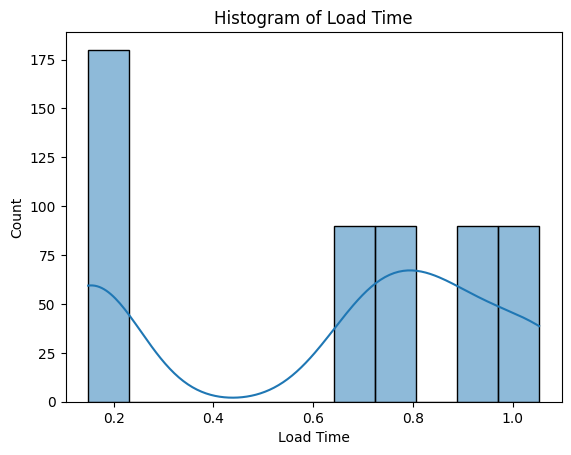

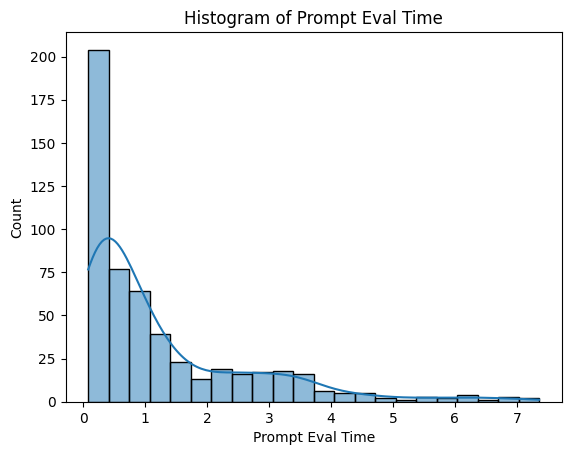

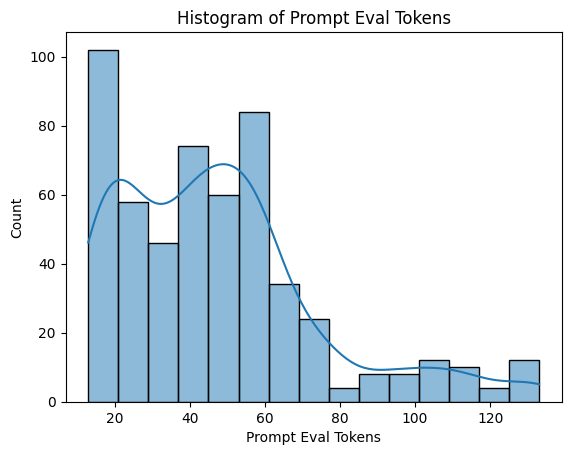

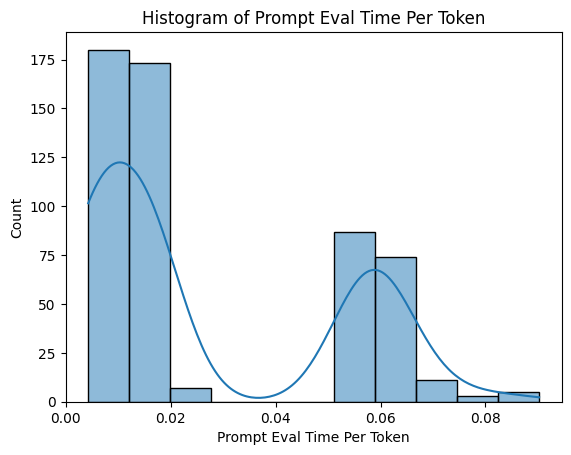

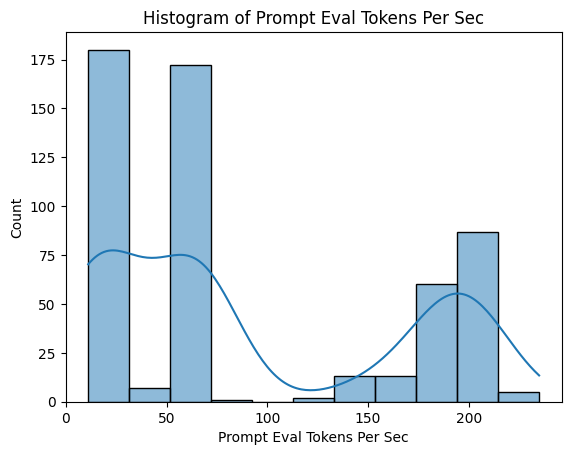

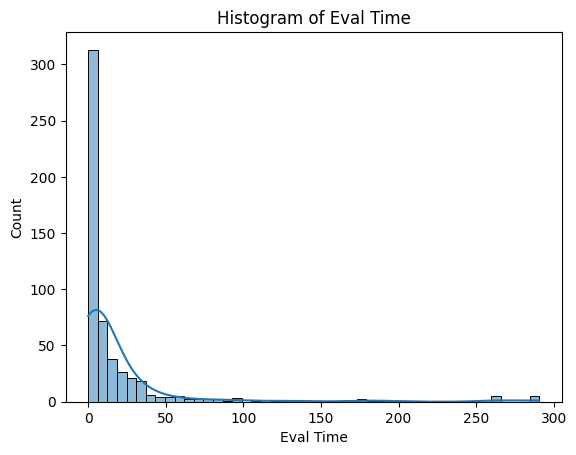

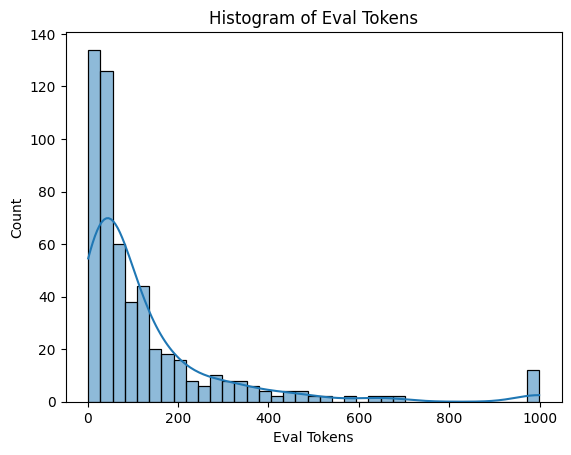

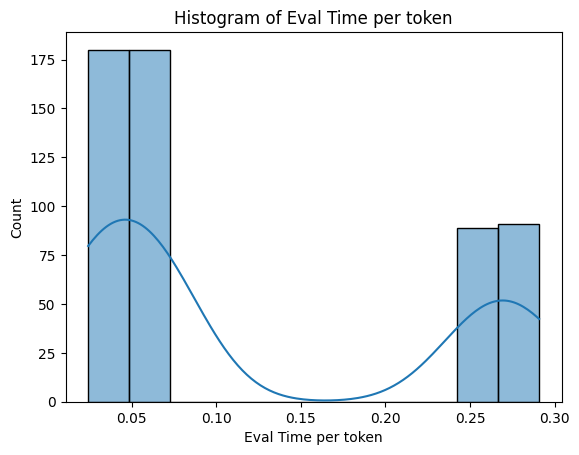

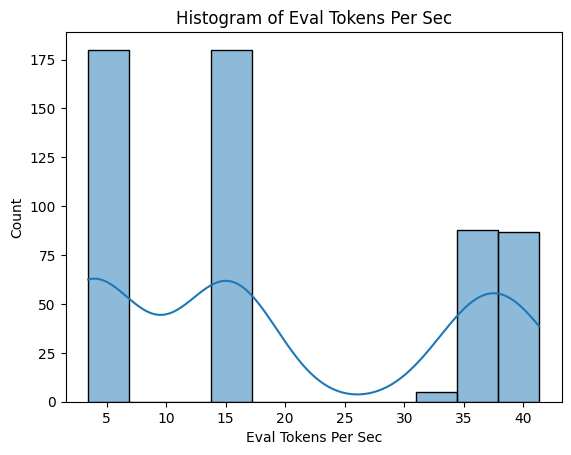

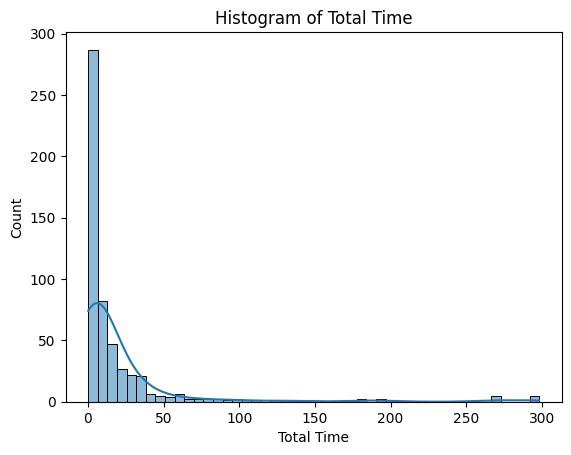

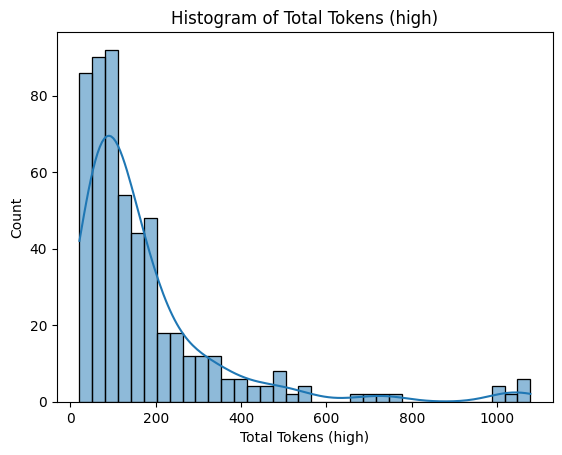

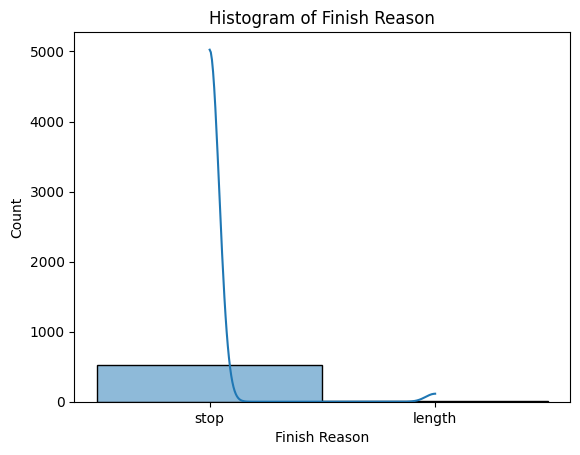

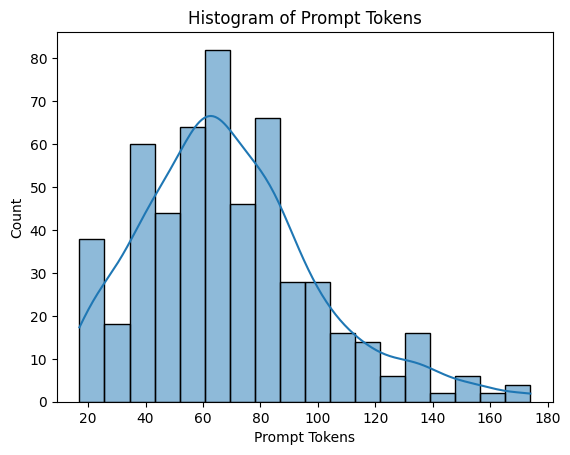

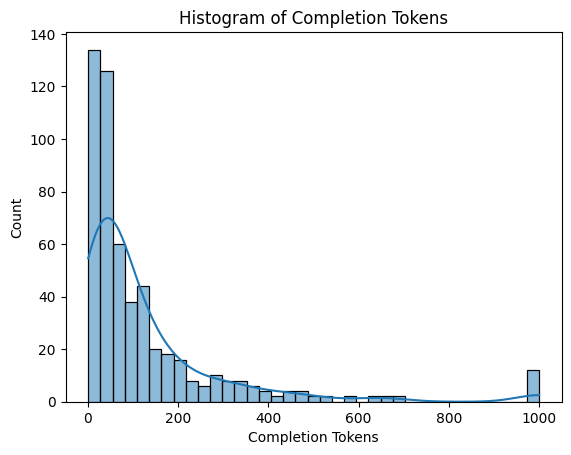

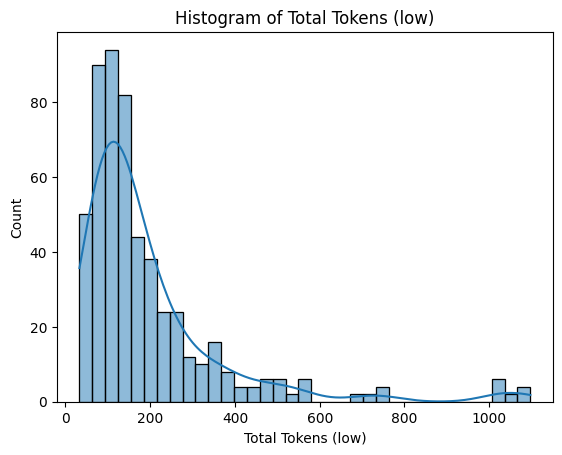

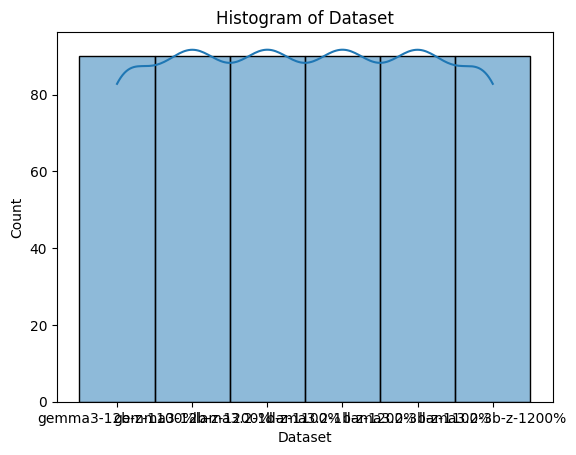

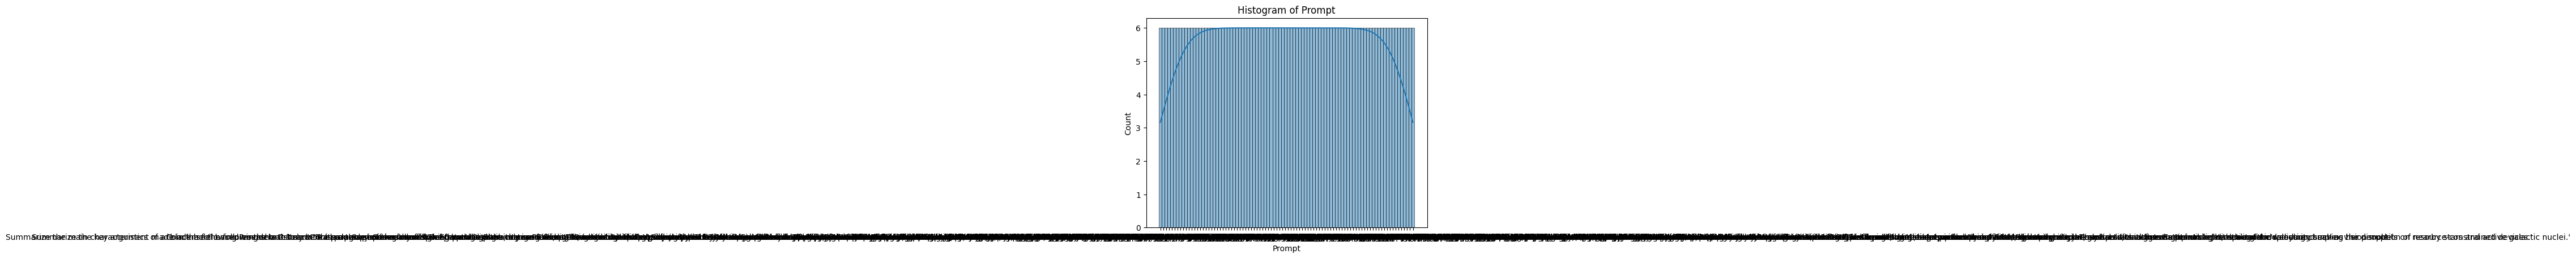

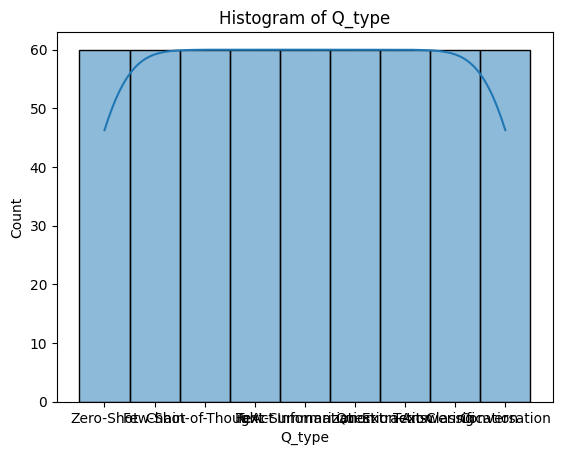

In [291]:
# Loop through each column in the DataFrame
for column in combined_dataframe.columns:
    plt.figure() # Create a new figure for each plot
    sns.histplot(data=combined_dataframe, x=column, kde=True)
    plt.title(f'Histogram of {column}')
    plt.show()
    